# Mustererkennung/Machine Learning - Assignment 8



In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from statistics import mean
import random
from numpy import linalg as LA
from sklearn import decomposition
%matplotlib inline

**Load data**

In [2]:
# https://vitalflux.com/convert-sklearn-dataset-pandas-dataframe/

# Load the IRIS dataset
iris = load_iris()
X = iris.data
y = iris.target
names = iris.target_names

#### Splitting the data into training/test and according to their class memberships

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y)

# data for training perceptron to distinguish between setosa and virginica/versicolour
X_train_setosa = X_train[np.where(y_train==0)]
X_train_versicolor = X_train[np.where(y_train==1)]
X_train_virginica = X_train[np.where(y_train==2)]
X_train_versicolor_virginica = np.concatenate((X_train_versicolor,X_train_virginica))

# data to test perceptron's performance to separate setosa from virginica/versicolour
# set setosa to positive class, versicolour/virginica to negative
y_test_setosa_vs_rest = (y_test == 0).astype(int)


# data to test perceptron's performance to separate versicolour from virginica
# make versicolour the positive class
X_test_versicolor_virginica = X_test[np.where(y_test!=0)]
y_test_versicolor_virginica = y_test[np.where(y_test!=0)]
y_test_versicolor_virginica = (y_test_versicolor_virginica == 1).astype(int)


## Exercise 1: Perceptron
Implement the Perceptron algorithm using Python (incl. Numpy etc.) and use it on the Iris-dataset. Train the algorithm to seperate Setosa from Versicolour and Virginica

In [4]:
class Perceptron:
    def __init__(self, threshold):
        self.threshold = threshold
        self.w_hat = None
        # If bias is implicitly given by data mean, then by centering the
        # data before prediction shouldn't the bias be already considered
        #self.b = None
        
    def center_data(self, P_X, N_X):
        # subtract mean from data
        # Center data by mean scalar or mean vector? => checked with multiple
        # implementations and sklearn, mean for each variable is subtracted
        m = np.mean(np.concatenate((P_X, N_X)), axis=0)
        return P_X-m, N_X-m
    
    def train(self, P_X, N_X):
        # center data
        P_centered, N_centered = self.center_data(P_X, N_X)
        # initialize w_hat
        self.w_hat = np.average(P_centered, axis=0)
        print('Initialize weights:', self.w_hat)
        w = self.w_hat
        while np.linalg.norm(self.w_hat - w) <= self.threshold:
            w = self.w_hat
            # select random vector v in NUP
            # randomly choose if taking from N or from P
            tmp = np.random.choice([0,1])
            # if v in P
            if tmp == 1:
                v = np.random.choice(range(P_centered.shape[0]))
                v = P_centered[v,:]
                # if projection of v onto w is positive, continue,
                # else update w_hat with v
                if w @ v <= 0:
                    self.w_hat = w + v
            # if v in N
            else:
                v = np.random.choice(range(N_centered.shape[0]))
                v = N_centered[v,:]                
                # if projection of v onto w is negative, continue,
                # else update w_hat with v
                if w @ v >= 0:
                    self.w_hat = w - v
        print('Final weights:', self.w_hat)
    
    def predict(self, X):
        # center data before prediction?? (or centering <=> subtract bias?)
        m = np.mean(X, axis=0)
        X_centered = X-m
        Y_pred = (X@self.w_hat > 0).astype(int)
        return Y_pred
    
    
    def accuracy(self, labels, predictions):
        return np.mean(labels == predictions)

**Train single perceptron to distinguish between setosa vs versicolour and virginica:**

In [5]:
Single_Perceptron = Perceptron(0.001)

In [6]:
Single_Perceptron.train(X_train_setosa, X_train_versicolor_virginica)

Initialize weights: [-0.81583333  0.33583333 -2.25833333 -0.95      ]
Final weights: [-0.625   0.4675 -2.1525 -1.055 ]


**Visualize training data and learned weight vector**

In [7]:
pca = decomposition.PCA(n_components=2)
# center training data to have perceptron weight vector with respect to zero mean
X_centered = X_train - X_train.mean(axis=0)
pca.fit(np.concatenate((X_centered,[Single_Perceptron.w_hat])))
X = pca.fit_transform(np.concatenate((X_centered,[Single_Perceptron.w_hat])))

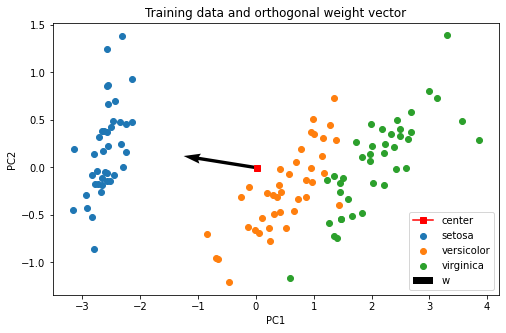

In [8]:
fig, ax = plt.subplots(1, figsize=(8,5))
data = X[:-1,:]- X[:-1,:].mean(axis=0)
for i in range(len(names)):
    ax.scatter(data[np.where(y_train==i),0], data[np.where(y_train==i),1], label=names[i])
ax.plot(X[:-1,:].mean(axis=0)[0],X[:-1,:].mean(axis=0)[1],c='red', marker='s', label='center')
tail = X[:-1,:].mean(axis=0)
ax.quiver(*tail,X[-1,0], X[-1,1], scale=15, label='w') 
ax.legend()
ax.set_title('Training data and orthogonal weight vector')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

**Evaluate performance**

In [9]:
y_pred = Single_Perceptron.predict(X_test)

In [10]:
print('Accuracy:',Single_Perceptron.accuracy(y_test_setosa_vs_rest, y_pred))

Accuracy: 0.6666666666666666


## (a) What happens if you use the algorithm to seperate Versicolour from Virginica? (Evaluate multiple runs)

### a.i) Using the single perceptron trained earlier

In [11]:
y_pred_versicolour_vs_virginica = Single_Perceptron.predict(X_test_versicolor_virginica)


In [12]:
print('Accuracy:',Single_Perceptron.accuracy(y_test_versicolor_virginica, y_pred_versicolour_vs_virginica))

Accuracy: 0.5


In [13]:
# Show how many items of each class the test set contains
np.unique(y_test_versicolor_virginica, return_counts=True)

(array([0, 1]), array([10, 10], dtype=int64))

In [14]:
# show how many itesm for each predicted class exist in the output labels
np.unique(y_pred_versicolour_vs_virginica, return_counts=True)

(array([0]), array([20], dtype=int64))

**Result**

Applying a perceptron classifier trained to separate setosa flowers from virginica and versicolour to predict species for an unlabelled set of only versicolours and virginicas leads to a classification performance equal to random guessing. The orthogonal vector w was trained to produce negative projections for versicolour and virginica which it actually did as shown by the label count in the returned prediction array. Yet, because we forced the perceptron evaluation to consider a class as positive that it naturally considers to be negative leads to poor evaluation results. 



### a.ii) Using a newly trained Perceptron

In [17]:
%%capture
acc_list = []
for i in range(100):
    clf_versicolor_virginica = Perceptron(threshold = 0.001)
    clf_versicolor_virginica.train(X_train_versicolor, X_train_virginica) # versicolor is the positive class

    y_pred_versicolor_virginica = clf_versicolor_virginica.predict(X_test_versicolor_virginica)

    acc_list.append(clf_versicolor_virginica.accuracy(y_test_versicolor_virginica, y_pred_versicolor_virginica))

In [18]:
print("Versicolor vs Virginica mean accuracy:", np.mean(acc_list))

Versicolor vs Virginica mean accuracy: 0.5


#### Result:
Even with a bunch of newly trained classifiers on versicolor and virginica, the accuracy is still only a random 50%

#### Show the vector w_hat of one of the Perceptrons:

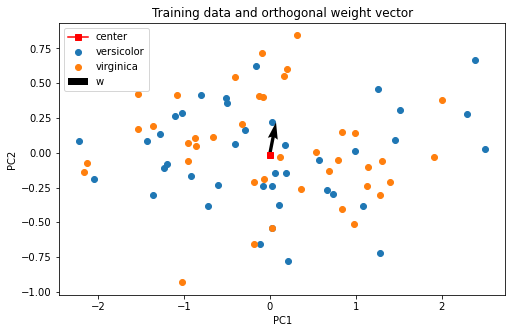

In [33]:
pca_v_v = decomposition.PCA(n_components=2)
X_train_v_v = np.concatenate((X_train_versicolor, X_train_virginica))
y_train_v_v = y_train[np.where(y_train!=0)]
X_centered_v_v = X_train_v_v - X_train_v_v.mean(axis=0)
pca.fit(np.concatenate((X_centered_v_v,[clf_versicolor_virginica.w_hat])))
X_v_v = pca.fit_transform(np.concatenate((X_centered_v_v,[clf_versicolor_virginica.w_hat])))

fig, ax = plt.subplots(1, figsize=(8,5))
data_v_v = X_v_v[:-1,:]- X_v_v[:-1,:].mean(axis=0)
for i in range(1,3):
    ax.scatter(data_v_v[np.where(y_train_v_v==i),0], data_v_v[np.where(y_train_v_v==i),1], label=names[i])
ax.plot(X_v_v[:-1,:].mean(axis=0)[0],X_v_v[:-1,:].mean(axis=0)[1],c='red', marker='s', label='center')
tail = X_v_v[:-1,:].mean(axis=0)
ax.quiver(*tail,X_v_v[-1,0], X_v_v[-1,1], scale=15, label='w') 
ax.legend()
ax.set_title('Training data and orthogonal weight vector')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

#### Result:
It seems like the problem is that versicolor and virginica are not linearly seperable.

**(b) Find a way to solve the problem and obtain the accuracy.**

## Excercise 2: Multilayer-Perceptron (MLP)
Implement a class that builds an MLP with both variable depth D (number of layers) and variable number of neurons ni for each layer i = 1,...,D.

In [64]:
class MLP:
    def __init__(self, threshold, depth, layer_width):
        self.threshold = threshold
        self.depth = depth
        if not len(layer_width) == (depth + 1):
            raise Exception("'layer_width' needs to be of length 'depth' + 1")  
        self.layer_width = layer_width
        self.network_weights = []
        self.network_biases = []
        width_prev = self.layer_width[0]
        for width in self.layer_width[1:]:
            self.network_weights.append(np.random.randn(width_prev, width)* np.sqrt(1. / width_prev))
            self.network_biases.append(np.zeros((1, width)))
            width_prev = width
        
    def center_data(self, P_X, N_X):
        mean = (np.concatenate((P_X, N_X))).mean()
        self.b = mean
        return P_X - mean, N_X - mean
    
    def heaviside(self, X):
        return (X > 0).astype(int)
    
    def iterate_trough_network(self, X):
        X_i = X.copy()
        for i in range(self.depth):
            z_i = X_i @ self.network_weights[i] + self.network_biases[i]
            X_i = self.heaviside(z_i)
        return X_i
    
    def train(self, X):
        raise Exception("The train function will be implemented in Assignment 9!!!")
    
    def predict(self, X):
        return (self.iterate_trough_network(X)).ravel()
    
    def accuracy(self, labels, predictions):
        return np.mean(labels == predictions)

### Produce outputs on the ZIP- Dataset.

#### Load the Zip Dataset

In [46]:
path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train_zip, y_train_zip = training_data[:,1:-1], training_data[:,0]
X_test_zip, y_test_zip = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. You can choose which digits you want to classify youself

X_train_zip = X_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]
y_train_zip = y_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]

X_test_zip = X_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]
y_test_zip = y_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]

In [47]:
X_train_zip.shape

(2199, 256)

#### Classify the Zip-Dataset with the random initial weights

In [65]:
mlp_network = MLP(threshold=0.01, depth=2, layer_width=[X_train_zip.shape[1], 10, 1])

In [66]:
print(mlp_network.network_weights[0].shape)
print(mlp_network.network_weights[1].shape)
print(mlp_network.network_biases[0].shape)
print(mlp_network.network_biases[1].shape)

(256, 10)
(10, 1)
(1, 10)
(1, 1)


In [67]:
y_pred_mlp = mlp_network.predict(X_train_zip)

In [68]:
mlp_network.accuracy(y_train_zip, y_pred_mlp)

0.5070486584811278

In [69]:
np.unique(y_pred_mlp, return_counts=True)

(array([0, 1]), array([2120,   79], dtype=int64))

In [70]:
np.unique(y_train_zip, return_counts=True)

(array([0., 1.]), array([1194, 1005], dtype=int64))

#### Get a mean accuracy over multiple runs

In [71]:
acc_list_mlp = []
n_runs = 100
for i in range(n_runs):
    mlp_network = MLP(threshold=0.01, depth=2, layer_width=[X_train_zip.shape[1], 10, 1])
    y_pred_loop = mlp_network.predict(X_train_zip)
    acc_list_mlp.append(mlp_network.accuracy(y_train_zip, y_pred_loop))
print("Mean Acc over", n_runs, "runs, with random weights is:", np.mean(acc_list_mlp))

Mean Acc over 100 runs, with random weights is: 0.507344247385175
